## ■ "Daum" site에서 News Data를 수집한 후 worldcloud 그리기

In [1]:
## 기본
import numpy as np                    # numpy 패키지 가져오기
import pandas as pd                   # pandas 패키지 가져오기
import matplotlib.pyplot as plt       # 시각화 패키지 가져오기

## Text 데이터 처리
from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Hannanum

from collections import Counter
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings('ignore')


## (1) 해당 사이트 탐색 단계

###  ■ Daum 검색창에서 '인공지능'  입력 후 뉴스 페이지로 이동 - 해당 url 을 복사해서 url 변수에  insert

In [2]:
url ='https://search.daum.net/search?w=news&nil_search=btn&DA=NTB&enc=utf8&cluster=y&cluster_page=1&q=%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5'

req = requests.get(url)    # 해당 페이지를 가져옴

page = BeautifulSoup(req.text , 'html.parser')

print(page)


<!DOCTYPE doctype html>

<html class="unix unknown " lang="ko" xmlns="http://www.w3.org/1999/xhtml">
<head profile="http://a9.com/-/spec/opensearch/1.1/">
<meta content="text/html;charset=utf-8" http-equiv="content-Type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="off" name="autocomplete"/>
<meta content="always" name="referrer"/>
<meta content="telephone=no" name="format-detection">
<meta content="인공지능 – Daum 검색" property="og:title"/>
<meta content="https://search.daum.net/search?w=news&amp;q=%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5" property="og:url"/>
<meta content="Daum 검색에서 인공지능에 대한 최신정보를 찾아보세요." property="og:description"/>
<meta content="https://search1.daumcdn.net/search/statics/common/img/og_search.png" property="og:image"/>
<meta content="다음검색" property="og:site_name"/>
<title>인공지능 – Daum 검색</title>
<link href="//search.daum.net/OpenSearch.xml" rel="search" title="Daum" type="application/opensearchdescription+xml"/>
<link charset="utf-8" href="//search

### ▶ 검색 데이터의 headline 을 추출한다.

#### -  F12 (검사 모드) 누른 후 해당 소스의 태그 id 혹은 class 를 찾는다.

In [3]:
titles = page.find_all(attrs='f_link_b')

print(titles)

[<a class="f_link_b" href="http://v.media.daum.net/v/20210501213824080?f=o" onclick='smartLog(this, "dc=NNS&amp;d=263xPPNZJWWpmLTaXB&amp;pg=1&amp;r=1&amp;p=4&amp;rc=10&amp;e1=16hWxJmTql2y9rxiuO&amp;e3=0&amp;ext=dsid=263xPPNZJWWpmLTaXB", event, {"cpid": {"value": "16hWxJmTql2y9rxiuO"}});' target="_blank"><b>인공지능</b> 창업 경진대회 참가자 모집</a>, <a class="f_link_b" href="http://v.media.daum.net/v/20210430132219630?f=o" onclick='smartLog(this, "dc=NNS&amp;d=26bA4mYfJ3B8vNoUEA&amp;pg=1&amp;r=2&amp;p=4&amp;rc=10&amp;e1=16D_CSGigLDafrbBvU&amp;e3=0&amp;ext=dsid=26bA4mYfJ3B8vNoUEA", event, {"cpid": {"value": "16D_CSGigLDafrbBvU"}});' target="_blank">질병에 관해 묻고 답하는 <b>인공지능</b> '닥터앤서'</a>, <a class="f_link_b" href="http://v.media.daum.net/v/20210430080111073?f=o" onclick='smartLog(this, "dc=NNS&amp;d=268wlnlvmA5OV6qBCG&amp;pg=1&amp;r=3&amp;p=4&amp;rc=10&amp;e1=16hWxJmTql2y9rxiuO&amp;e3=0&amp;ext=dsid=268wlnlvmA5OV6qBCG", event, {"cpid": {"value": "16hWxJmTql2y9rxiuO"}});' target="_blank">자가격리 건강 상태, '<b>인

### ▶ 검색된 title의 크기를 확인한다.

In [4]:
print(len(titles))

10


### ▶ 검색된 title의 각각을 프린트 한다.

In [5]:
for title in titles :
    print(title.text)
    print()

인공지능 창업 경진대회 참가자 모집

질병에 관해 묻고 답하는 인공지능 '닥터앤서'

자가격리 건강 상태, '인공지능'으로 확인

광주시, 인공지능 창업 경진대회 참가자 모집

밀양시, 5월 온라인 강연은 AI(인공지능)

대전을 데이터·네트워크·인공지능 기반 스마트도시로 만든다

광주광역시, 인공지능 산업육성 포럼 개최

로보마스터로 인공지능 공부하기

[인공지능 기술 청사진 2030] ④신뢰성 있는 AI

아이반 자작곡 '인공지능' 오디오 티저 공개



## (2) 본격 스크래핑 단계 


### ▶ 첫 페이지부터 원하는 페이지 까지 뉴스 헤드라인을 스크래핑하는 함수 정의

In [6]:
# 해드라인 검색 및 추출 함수를 정의
# 검색 키워드 & 스타트 페이지 & 검색 마지막 페이지를 parameter(매개변수) 로 받음
# 파이썬은 매개변수가 여러개 인 경우 뒤의 매개 변수부터 디폴트값을 가질 수 있음 

title_list = []

def web_scraping(keyword, end, start = 1):    # 시작 페이지의 default 값은 1 (즉, 첫 페이지 부터 시작) 
    while 1:
        
        if start > end :    # 스타트 페이지가 마지막 페이지보다 크면 while 문을 빠져 나감 
            break    
            
        url ='https://search.daum.net/search?w=news&nil_search=btn&DA=NTB&enc=utf8&cluster=y&cluster_page=1&q={}&p={}'.format(keyword,start)
        
        req = requests.get(url)    # 해당 페이지를 가져옴

        page = BeautifulSoup(req.text, 'html.parser')
        titles = page.find_all(attrs='f_link_b')     # 헤드라인 기사를 가져옴 
        print(titles)       # 추출한 헤드라인을 확인 (10개)

        for one in titles:
            title_list.append(one.text)
            
        start += 1        

### ▶ 위 함수를 호출

In [7]:
# 검색어를 입력 받음 

keyword = input('검색어를 입력하세요 : ')
print()

end_page = 10

web_scraping(keyword, end_page)       # 10 페이지 까지 스크래핑을 해온다.

검색어를 입력하세요 : 인공지능

[<a class="f_link_b" href="http://v.media.daum.net/v/20210501213824080?f=o" onclick='smartLog(this, "dc=NNS&amp;d=263xPPNZJWWpmLTaXB&amp;pg=1&amp;r=1&amp;p=4&amp;rc=10&amp;e1=16hWxJmTql2y9rxiuO&amp;e3=0&amp;ext=dsid=263xPPNZJWWpmLTaXB", event, {"cpid": {"value": "16hWxJmTql2y9rxiuO"}});' target="_blank"><b>인공지능</b> 창업 경진대회 참가자 모집</a>, <a class="f_link_b" href="http://v.media.daum.net/v/20210430132219630?f=o" onclick='smartLog(this, "dc=NNS&amp;d=26bA4mYfJ3B8vNoUEA&amp;pg=1&amp;r=2&amp;p=4&amp;rc=10&amp;e1=16D_CSGigLDafrbBvU&amp;e3=0&amp;ext=dsid=26bA4mYfJ3B8vNoUEA", event, {"cpid": {"value": "16D_CSGigLDafrbBvU"}});' target="_blank">질병에 관해 묻고 답하는 <b>인공지능</b> '닥터앤서'</a>, <a class="f_link_b" href="http://v.media.daum.net/v/20210430080111073?f=o" onclick='smartLog(this, "dc=NNS&amp;d=268wlnlvmA5OV6qBCG&amp;pg=1&amp;r=3&amp;p=4&amp;rc=10&amp;e1=16hWxJmTql2y9rxiuO&amp;e3=0&amp;ext=dsid=268wlnlvmA5OV6qBCG", event, {"cpid": {"value": "16hWxJmTql2y9rxiuO"}});' target="_blank

[<a class="f_link_b" href="http://v.media.daum.net/v/20210425162551974?f=o" onclick='smartLog(this, "dc=NNS&amp;d=2678FV9XJ3H_bBxwOL&amp;pg=4&amp;r=1&amp;p=4&amp;rc=10&amp;e1=166KT6l77lf-D_qcvA&amp;e3=0&amp;ext=dsid=2678FV9XJ3H_bBxwOL", event, {"cpid": {"value": "166KT6l77lf-D_qcvA"}});' target="_blank">광주<b>인공지능</b> 청년협회, 엑센트리벤처스와 투자 활성화 협약</a>, <a class="f_link_b" href="http://v.media.daum.net/v/20210429165424693?f=o" onclick='smartLog(this, "dc=NNS&amp;d=264cg8_iW4in_vGjfK&amp;pg=4&amp;r=2&amp;p=4&amp;rc=10&amp;e1=16gmjhh-4e7TNHMCYw&amp;e3=0&amp;ext=dsid=264cg8_iW4in_vGjfK", event, {"cpid": {"value": "16gmjhh-4e7TNHMCYw"}});' target="_blank">"<b>인공지능</b> 데이터 나누고 업계표준 세워라"</a>, <a class="f_link_b" href="http://v.media.daum.net/v/20210429091135540?f=o" onclick='smartLog(this, "dc=NNS&amp;d=26tHSImozdt8GQONUh&amp;pg=4&amp;r=3&amp;p=4&amp;rc=10&amp;e1=16-6jSmzt99LyEgQia&amp;e3=0&amp;ext=dsid=26tHSImozdt8GQONUh", event, {"cpid": {"value": "16-6jSmzt99LyEgQia"}});' target="_blank">싱어송라이터 

[<a class="f_link_b" href="http://v.media.daum.net/v/20210430143300955?f=o" onclick='smartLog(this, "dc=NNS&amp;d=26ssXG2UXfKYf-PgU3&amp;pg=7&amp;r=1&amp;p=4&amp;rc=10&amp;e1=16O8sbGdUflWYlfqu4&amp;e3=0&amp;ext=dsid=26ssXG2UXfKYf-PgU3", event, {"cpid": {"value": "16O8sbGdUflWYlfqu4"}});' target="_blank">유어초이스바이씨랩, <b>인공지능</b> 기반해 피부 분석 토탈 솔루션 제...</a>, <a class="f_link_b" href="http://v.media.daum.net/v/20210422173240940?f=o" onclick='smartLog(this, "dc=NNS&amp;d=26JdCuvFiYl84s7XV-&amp;pg=7&amp;r=2&amp;p=4&amp;rc=10&amp;e1=16JfL24RCJKYboAM86&amp;e3=0&amp;ext=dsid=26JdCuvFiYl84s7XV-", event, {"cpid": {"value": "16JfL24RCJKYboAM86"}});' target="_blank">포스코, '주니어 <b>인공지능</b> 온라인 캠프' 오픈..올해 4회 진행</a>, <a class="f_link_b" href="http://v.media.daum.net/v/20210428103609164?f=o" onclick='smartLog(this, "dc=NNS&amp;d=26d35slHsN9YsRZyoT&amp;pg=7&amp;r=3&amp;p=4&amp;rc=10&amp;e1=16sIQ8rx97vi9RHx8w&amp;e3=0&amp;ext=dsid=26d35slHsN9YsRZyoT", event, {"cpid": {"value": "16sIQ8rx97vi9RHx8w"}});' targe

[<a class="f_link_b" href="http://v.media.daum.net/v/20210418110304845?f=o" onclick='smartLog(this, "dc=NNS&amp;d=26uxEGB8bUSl5IgxQD&amp;pg=10&amp;r=1&amp;p=4&amp;rc=10&amp;e1=16iL25JCNSvhQN0hEU&amp;e3=0&amp;ext=dsid=26uxEGB8bUSl5IgxQD", event, {"cpid": {"value": "16iL25JCNSvhQN0hEU"}});' target="_blank">광주시, <b>인공지능</b> 융합대학 지원 사업 공모</a>, <a class="f_link_b" href="https://cp.news.search.daum.net/p/105739402" onclick='smartLog(this, "dc=NNS&amp;d=26qf-Cln9zhc9Cb1VF&amp;pg=10&amp;r=2&amp;p=4&amp;rc=10&amp;e1=16seOavmvqhEs4mk-m&amp;e3=0&amp;ext=dsid=26qf-Cln9zhc9Cb1VF", event, {"cpid": {"value": "16seOavmvqhEs4mk-m"}});' target="_blank">충북도, KT와 광역지자체 최초 <b>인공지능</b>(AI) 활용 MOU 체결</a>, <a class="f_link_b" href="https://cp.news.search.daum.net/p/105731347" onclick='smartLog(this, "dc=NNS&amp;d=26exVHiKfvNlBaLWDa&amp;pg=10&amp;r=3&amp;p=4&amp;rc=10&amp;e1=16IoX6Lar16lqJw2IR&amp;e3=0&amp;ext=dsid=26exVHiKfvNlBaLWDa", event, {"cpid": {"value": "16IoX6Lar16lqJw2IR"}});' target="_blank">경북도 공무원

In [8]:
# 수집해온 헤드라인 갯수를 확인 

print(len(title_list))

100


## (3) 데이터 분석 단계


### ▶ 형태소 분석

In [9]:
# 형태소 분석 - 분석하는데 약간의 시간이 걸림 

kkma = Kkma()

sentences_tag = []

for sentence in title_list:
    word_tag = kkma.pos(sentence)
    sentences_tag.append(word_tag)


print(sentences_tag)

[[('인공지능', 'NNG'), ('창업', 'NNG'), ('경진', 'NNG'), ('대회', 'NNG'), ('참가자', 'NNG'), ('모질', 'VA')], [('질병', 'NNG'), ('에', 'JKM'), ('관하', 'VV'), ('어', 'ECS'), ('묻', 'VV'), ('고', 'ECE'), ('답하', 'VV'), ('는', 'ETD'), ('인공지능', 'NNG'), ("'", 'SS'), ('닥터', 'NNG'), ('앤', 'NNG'), ('서', 'JKM'), ("'", 'SS')], [('자가', 'NNG'), ('격리', 'NNG'), ('건강', 'NNG'), ('상태', 'NNG'), (',', 'SP'), ("'", 'SS'), ('인공지능', 'NNG'), ("'", 'SS'), ('으로', 'JKM'), ('확인', 'NNG')], [('광주시', 'NNG'), (',', 'SP'), ('인공지능', 'NNG'), ('창업', 'NNG'), ('경진', 'NNG'), ('대회', 'NNG'), ('참가자', 'NNG'), ('모질', 'VA')], [('밀양시', 'NNP'), (',', 'SP'), ('5', 'NR'), ('월', 'NNM'), ('온라인', 'NNG'), ('강연', 'NNG'), ('은', 'JX'), ('AI', 'OL'), ('(', 'SS'), ('인공지능', 'NNG'), (')', 'SS')], [('대전', 'NNG'), ('을', 'JKO'), ('데이터', 'NNG'), ('·', 'SP'), ('네트워크', 'NNG'), ('·', 'SP'), ('인공지능', 'NNG'), ('기반', 'NNG'), ('스마트', 'NNG'), ('도시', 'NNG'), ('로', 'JKM'), ('만들', 'VV'), ('ㄴ다', 'EFN')], [('광주', 'NNG'), ('광역시', 'NNG'), (',', 'SP'), ('인공지능', 'NNG'), ('산업', 'NNG'), ('

### ▶ 명사 추출

In [10]:
# 형태소 분석 후 명사만 추출

noun_list = []

for sentence in sentences_tag:
    for word, tag in sentence:
        if tag in ['NNG']:               # okt = Okt() 인 경우  if tag in ['Noun']:
            noun_list.append(word)
            
print(noun_list)

['인공지능', '창업', '경진', '대회', '참가자', '질병', '인공지능', '닥터', '앤', '자가', '격리', '건강', '상태', '인공지능', '확인', '광주시', '인공지능', '창업', '경진', '대회', '참가자', '온라인', '강연', '인공지능', '대전', '데이터', '네트워크', '인공지능', '기반', '스마트', '도시', '광주', '광역시', '인공지능', '산업', '육성', '포럼', '개최', '마스터', '인공지능', '공부', '인공지능', '기술', '청사진', '신뢰성', '아이', '반', '자', '작곡', '인공지능', '오디오', '티', '공개', '인공지능', '암', '정복', '의료', '산업', '기고', '인공지능', '기술', '윤리', '문제', '대처', '방법', '광주시', '인공지능', '분야', '기관', '투자', '유치', '설명회', '인', '하대', '인공지능', '융합', '연구', '센터', '충북', '인공지능', '활용', '자가', '격리', '모니터링', '업무', '협약', '단국', '대', '학생', '인공지능', '비서', '제공', '서울', '뉴딜', '일자리', '학습', '데이터', '구축', '사업', '한국', '인공지능', '협회', '아이', '반', '연출', '인공지능', '비', '기대감', '소비자', '민원', '인공지능', '해결', '민원', '기의', '디지털', '경제', '유럽', '연합', '인공지능', '규제', '안', '의', '의미', '신', '제품', '신', '기술', '머니', '브레인', '인공지능', '키', '아이', '반', '새', '싱글', '인공지능', '티', '공개', '호남', '대학교', '인공지능', '신기술', '릴레이', '특강', '충남', '교육청', '선', '문', '대', '인공지능', '학생', '동아리', '지원', '인천', '과학', '예술', '영재', '

### ▶ 두음절 이상 단어만 추출

In [11]:
# 명사 중에서 두음절 단어만 추출 


print('▶ 전체 명사의 수 = ', len(noun_list))
print() 

noun_list = [word for word in noun_list if len(word) > 1]    # 명사중에서 두음절 이상의 단어 추출


print('▶ 두음절 이상의 명사의 수 = ', len(noun_list))
print() 

print(noun_list[:100])   # 처음부터 나오는 순서대로 100개 단어 출력 

▶ 전체 명사의 수 =  723

▶ 두음절 이상의 명사의 수 =  620

['인공지능', '창업', '경진', '대회', '참가자', '질병', '인공지능', '닥터', '자가', '격리', '건강', '상태', '인공지능', '확인', '광주시', '인공지능', '창업', '경진', '대회', '참가자', '온라인', '강연', '인공지능', '대전', '데이터', '네트워크', '인공지능', '기반', '스마트', '도시', '광주', '광역시', '인공지능', '산업', '육성', '포럼', '개최', '마스터', '인공지능', '공부', '인공지능', '기술', '청사진', '신뢰성', '아이', '작곡', '인공지능', '오디오', '공개', '인공지능', '정복', '의료', '산업', '기고', '인공지능', '기술', '윤리', '문제', '대처', '방법', '광주시', '인공지능', '분야', '기관', '투자', '유치', '설명회', '하대', '인공지능', '융합', '연구', '센터', '충북', '인공지능', '활용', '자가', '격리', '모니터링', '업무', '협약', '단국', '학생', '인공지능', '비서', '제공', '서울', '뉴딜', '일자리', '학습', '데이터', '구축', '사업', '한국', '인공지능', '협회', '아이', '연출', '인공지능', '기대감', '소비자']


### ▶ 추출된 단어들의 출현 횟수를 확인

In [12]:
# 단어의 출현 횟수 카운트

counts = Counter(noun_list)

words = counts.most_common(50)     # 가장 많이 출현한 횟수 순으로 50개 단어만 추출 한 후 word clouding  

print(words)


[('인공지능', 101), ('아이', 10), ('교육', 9), ('활용', 8), ('광주시', 7), ('데이터', 7), ('기반', 6), ('지원', 6), ('개발', 6), ('기술', 5), ('공개', 5), ('최초', 5), ('산업', 4), ('육성', 4), ('의료', 4), ('학생', 4), ('사업', 4), ('교육청', 4), ('시스템', 4), ('솔루션', 4), ('포럼', 3), ('개최', 3), ('투자', 3), ('융합', 3), ('센터', 3), ('충북', 3), ('협약', 3), ('단국', 3), ('제공', 3), ('서울', 3), ('학습', 3), ('협회', 3), ('연출', 3), ('싱글', 3), ('선정', 3), ('시대', 3), ('운영', 3), ('대학', 3), ('서비스', 3), ('광역', 3), ('지자체', 3), ('체결', 3), ('칼럼', 3), ('미래', 3), ('창업', 2), ('경진', 2), ('대회', 2), ('참가자', 2), ('자가', 2), ('격리', 2)]


### ▶ 단어 출현 횟수에 근거하여 word cloud 를 생성

{'인공지능': 101, '아이': 10, '교육': 9, '활용': 8, '광주시': 7, '데이터': 7, '기반': 6, '지원': 6, '개발': 6, '기술': 5, '공개': 5, '최초': 5, '산업': 4, '육성': 4, '의료': 4, '학생': 4, '사업': 4, '교육청': 4, '시스템': 4, '솔루션': 4, '포럼': 3, '개최': 3, '투자': 3, '융합': 3, '센터': 3, '충북': 3, '협약': 3, '단국': 3, '제공': 3, '서울': 3, '학습': 3, '협회': 3, '연출': 3, '싱글': 3, '선정': 3, '시대': 3, '운영': 3, '대학': 3, '서비스': 3, '광역': 3, '지자체': 3, '체결': 3, '칼럼': 3, '미래': 3, '창업': 2, '경진': 2, '대회': 2, '참가자': 2, '자가': 2, '격리': 2}


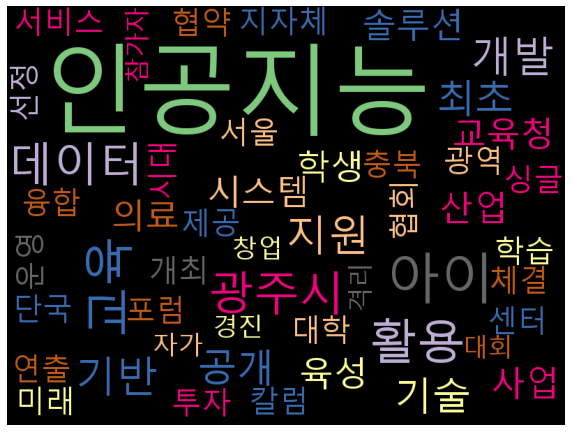

In [13]:
# wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
#                       background_color='white',                   
#                       colormap = 'Accent_r',   
#                       width=800,
#                       height=600)

wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                      colormap = 'Accent_r',
                      width=800,
                      height=600)

print(dict(words))

cloud = wordcloud.generate_from_frequencies(dict(words))

plt.figure(figsize=(10, 8))

plt.axis('off')   

plt.imshow(cloud)

plt.show()